In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import pandas as pd
import seaborn as sns
import pyro
import torch
import arviz as az
import numpyro
import jax
import jax.numpy as jnp
plt.style.use('seaborn-darkgrid')
np.set_printoptions(precision=2)
pd.set_option('display.precision', 2)

## The gamma distribution

In [88]:
rates = [1, 2, 5]
scales = [1, 2, 3]

x = np.linspace(0, 20, 100)
f, ax = plt.subplots(len(rates), len(scales), sharex=True, sharey=True)
for i in range(len(rates)):
    for j in range(len(scales)):
        rate = rates[i]
        scale = scales[j]
        rv = stats.gamma(a=rate, scale=scale)
        ax[i,j].plot(x, rv.pdf(x))
        ax[i,j].plot(0, 0, 
        label="$\\alpha$ = {:3.2f}\n$\\theta$ = {:3.2f}".format(rate, scale), alpha=0)
        ax[i,j].legend()
ax[2,1].set_xlabel('$x$')
ax[1,0].set_ylabel('$pdf(x)$')
plt.savefig('B04958_04_00.png', dpi=300);
plt.show()

<Figure size 432x288 with 9 Axes>


## Simple linear regression

$$\alpha \sim {\rm Normal}(\mu_\alpha, \sigma_\alpha)$$
$$\beta \sim {\rm Normal}(\mu_\beta, \sigma_\beta)$$
$$\epsilon \sim {\rm Uniform(0, h_s)}$$
$${\boldsymbol y} \sim {\rm Normal}(\mu=\alpha+\beta{\boldsymbol x}, \sigma =\epsilon)$$

In [3]:
np.random.seed(1)
N = 100
alfa_real = 2.5
beta_real = 0.9
eps_real = np.random.normal(0, 0.5, size=N)

x = np.random.normal(10, 1, N)
y_real = alfa_real + beta_real * x 
y = y_real + eps_real

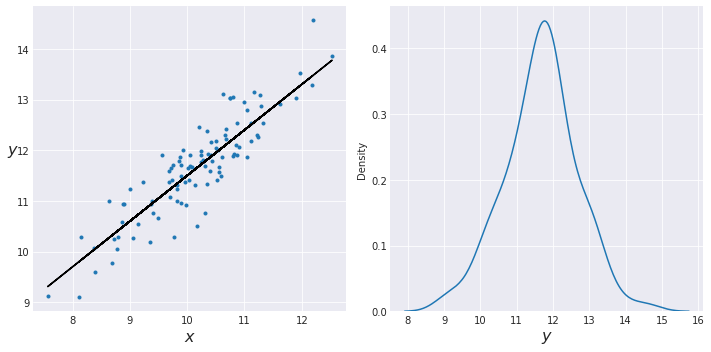

In [4]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(x, y, 'C0.')
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0)
plt.plot(x, y_real, 'k')
plt.subplot(1,2,2)
sns.kdeplot(y)
plt.xlabel('$y$', fontsize=16)
plt.tight_layout()
plt.savefig('B04958_04_02.png', dpi=300)

$$\alpha \sim {\rm Normal}(\mu_\alpha, \sigma_\alpha)$$
$$\beta \sim {\rm Normal}(\mu_\beta, \sigma_\beta)$$
$$\epsilon \sim {\rm HalfCauchy(\sigma_\sigma)}$$
$${\boldsymbol y} \sim {\rm Normal}(\mu=\alpha+\beta{\boldsymbol x}, \sigma =\epsilon)$$

In [5]:
def model(x, y=None):
    alpha = pyro.sample("alpha", pyro.distributions.Normal(0, 10))
    beta = pyro.sample("beta", pyro.distributions.Normal(0, 1))
    epsilon = pyro.sample("epsilon", pyro.distributions.HalfCauchy(5))
    with pyro.plate("data", size = len(x)):
        mu = alpha + beta * x
        y = pyro.sample("y", pyro.distributions.Normal(mu, epsilon), obs=y)
    return mu

nuts_kernel = pyro.infer.mcmc.NUTS(model) # Pyro do not implement Metropolis
mcmc_run = pyro.infer.mcmc.MCMC(nuts_kernel, num_samples=1000, warmup_steps=100, num_chains=1)
mcmc_run.run(torch.tensor(x), torch.tensor(y))

Sample: 100%|██████████| 1100/1100 [01:04, 16.93it/s, step size=7.02e-02, acc. prob=0.916]


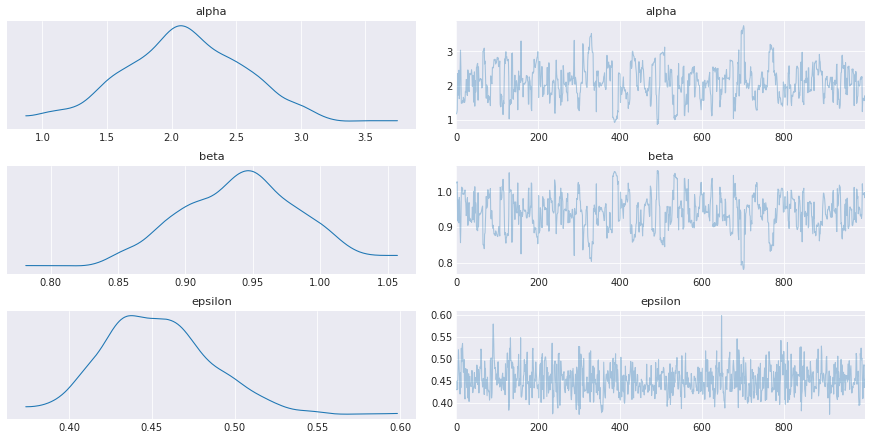

In [6]:
az.plot_trace(mcmc_run)
plt.savefig('B04958_04_03.png', dpi=300)

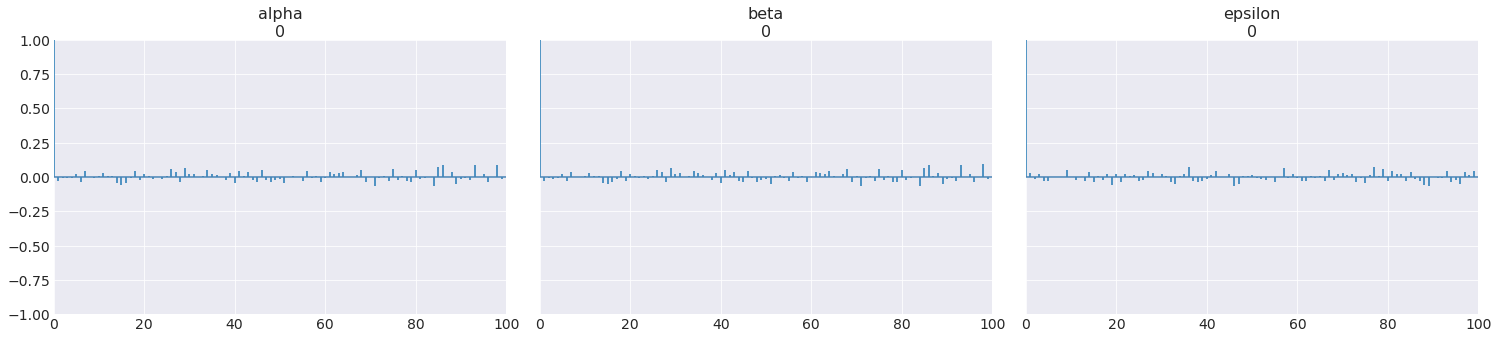

In [7]:
varnames = ['alpha', 'beta', 'epsilon']
trace = mcmc_run.get_samples(1100)
az.plots.autocorrplot.plot_autocorr(az.convert_to_dataset(trace))
plt.savefig('B04958_04_04.png', dpi=300)

### Modyfing the data before running the models

/home/kajyuuen/.pyenv/versions/3.7.5/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/kajyuuen/.pyenv/versions/3.7.5/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error two minor releases later
  after removing the cwd from sys.path.


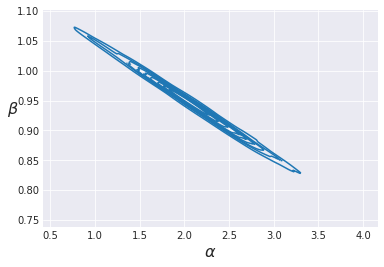

In [8]:
sns.kdeplot(trace['alpha'], trace['beta'])
plt.xlabel(r'$\alpha$', fontsize=16)
plt.ylabel(r'$\beta$', fontsize=16, rotation=0)
plt.savefig('B04958_04_05.png', dpi=300, figsize=(5.5, 5.5));

In [9]:
az.summary(trace, varnames)

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 1100), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 1100), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 1100), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,2.10,0.48,1.23,3.10,1.40e-02,1.00e-02,1173.0,1173.0,1172.0,947.0,NaN
beta,0.94,0.05,0.87,1.05,1.00e-03,1.00e-03,1168.0,1167.0,1176.0,842.0,NaN
epsilon,0.45,0.03,0.40,0.51,1.00e-03,1.00e-03,1040.0,1031.0,1054.0,999.0,NaN


### Posterior predictive checks

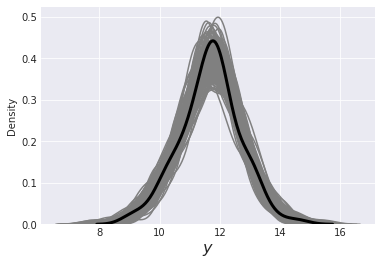

In [10]:
y_preds = pyro.infer.Predictive(model, mcmc_run.get_samples(231))(x)
_, ax = plt.subplots()
for y_pred in y_preds["y"]:
    sns.kdeplot(y_pred.detach().numpy(), alpha=00.1, c='gray', ax=ax)
# actual data
sns.kdeplot(y, linewidth=3, color='k', ax=ax)
    
plt.xlabel('$y$', fontsize=16);

### interpreting the posterior


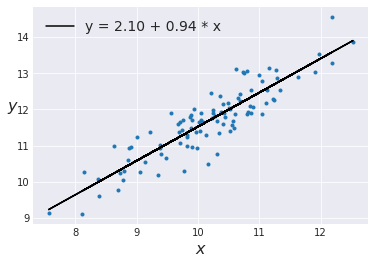

In [11]:
plt.plot(x, y, 'C0.');
alpha_m = trace['alpha'].mean()
beta_m = trace['beta'].mean()
plt.plot(x, alpha_m + beta_m * x,
         c='k', label='y = {:.2f} + {:.2f} * x'.format(alpha_m, beta_m))
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0)
plt.legend(loc=2, fontsize=14)
plt.savefig('B04958_04_06.png', dpi=300);

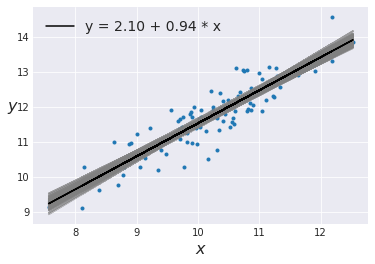

In [12]:
plt.plot(x, y, 'C0.');

idx = range(0, len(trace['alpha']), 10)
plt.plot(x, trace['alpha'][idx] + trace['beta'][idx] *  x[:,np.newaxis], c='gray', alpha=0.5);

plt.plot(x, alpha_m + beta_m * x, c='k',
         label='y = {:.2f} + {:.2f} * x'.format(alpha_m, beta_m))

plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0)
plt.legend(loc=2, fontsize=14)
plt.savefig('B04958_04_07.png', dpi=300)

In [13]:
predictive = pyro.infer.Predictive(model, 
                                   mcmc_run.get_samples(231),
                                   return_sites=["alpha", "beta", "epsilon", "y", "_RETURN"])
samples = predictive(x)

In [14]:
def summary(samples):
    site_stats = {}
    for k, v in samples.items():
        site_stats[k] = {
            "mean": torch.mean(v, 0),
            "std": torch.std(v, 0),
            "5%": v.kthvalue(int(len(v) * 0.05), dim=0)[0],
            "95%": v.kthvalue(int(len(v) * 0.95), dim=0)[0],
        }
    return site_stats
pred_summary = summary(samples)

In [15]:
mu = pred_summary["_RETURN"]
y_info = pred_summary["y"]
predictions = pd.DataFrame({
    "mu_mean": mu["mean"],
    "mu_perc_5": mu["5%"],
    "mu_perc_95": mu["95%"],
    "y_mean": y_info["mean"],
    "y_perc_5": y_info["5%"],
    "y_perc_95": y_info["95%"],
    "y": y,
})

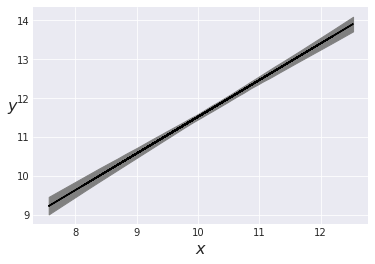

In [16]:
plt.plot(x, alpha_m + beta_m * x, c='k',
         label='y = {:.2f} + {:.2f} * x'.format(alpha_m, beta_m))

idx = np.argsort(x)
x_ord = x[idx]
plt.fill_between(x_ord, predictions["mu_perc_5"][idx], predictions["mu_perc_95"][idx], color='gray')

plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0)
plt.savefig('B04958_04_08.png', dpi=300)

/home/kajyuuen/.pyenv/versions/3.7.5/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error two minor releases later
  


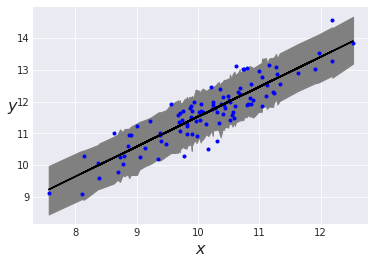

In [17]:
plt.plot(x, y, 'b.')
plt.plot(x, alpha_m + beta_m * x, c='k', label='y = {:.2f} + {:.2f} * x'.format(alpha_m, beta_m))

plt.fill_between(x_ord, predictions["y_perc_5"][idx], predictions["y_perc_95"][idx], color='gray', alpha=1)

plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0)
plt.savefig('B04958_04_09.png', dpi=300, figsize=(5.5, 5.5));

## Pearson correlation coefficient

$$r = \beta\frac{\sigma({\boldsymbol x})}{\sigma({\boldsymbol y})}$$

In [18]:
def model_n(x, y=None):
    alpha = pyro.sample("alpha", pyro.distributions.Normal(0, 10))
    beta = pyro.sample("beta", pyro.distributions.Normal(0, 1))
    epsilon = pyro.sample("epsilon", pyro.distributions.HalfCauchy(5))
    with pyro.plate("data", size = len(x)):
        mu = alpha + beta * x
        y = pyro.sample("y", pyro.distributions.Normal(mu, epsilon), obs=y)
        
    rb = (beta * x.std()/y.std())**2
    pyro.sample("rb", pyro.distributions.Delta(rb), obs=rb) # Pearson correlation coefficient

    y_mean = y.mean()
    ss_reg = torch.sum((mu - y_mean) ** 2)
    ss_tot = torch.sum((y - y_mean) ** 2)

    rss = ss_reg/ss_tot
    pyro.sample("rss", pyro.distributions.Delta(rss), obs=rss)

nuts_kernel_n = pyro.infer.mcmc.NUTS(model_n) # Pyro do not implement Metropolis
mcmc_run_n = pyro.infer.mcmc.MCMC(nuts_kernel_n, num_samples=1000, warmup_steps=100, num_chains=1)
mcmc_run_n.run(torch.tensor(x), torch.tensor(y))

Sample: 100%|██████████| 1100/1100 [00:55, 19.73it/s, step size=8.64e-02, acc. prob=0.926]


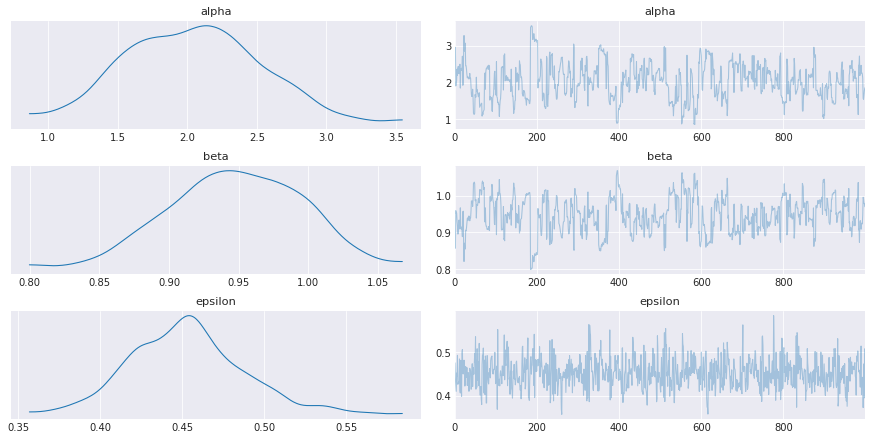

In [19]:
# 実装出来ず…

posterior = mcmc_run_n.get_samples()

posterior_predictive = pyro.infer.Predictive(model_n,
                                             posterior,
                                             return_sites=["alpha", "beta", "epsilon", "rb", "rss", "y"]).get_samples(x)
prior = pyro.infer.Predictive(model_n, num_samples=500, return_sites=["alpha", "beta", "epsilon", "rb", "rss", "y"]).get_samples(x)

pyro_data = az.from_pyro(
    mcmc_run_n,
    prior=prior,
    posterior_predictive=posterior_predictive)

az.plot_trace(pyro_data)
plt.savefig('B04958_04_10.png', dpi=300)

### The multivariate normal distribution 
Actually the bivariate

/home/kajyuuen/.pyenv/versions/3.7.5/lib/python3.7/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error two minor releases later


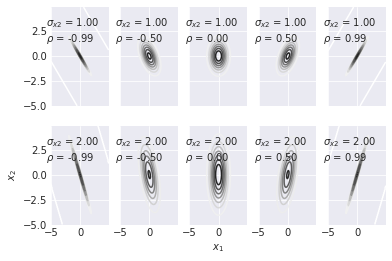

In [20]:
sigma_x1 = 1
sigmas_x2 = [1, 2]
rhos = [-0.99, -0.5, 0, 0.5, 0.99]

k, l = np.mgrid[-5:5:.1, -5:5:.1]
pos = np.empty(k.shape + (2,))
pos[:, :, 0] = k; pos[:, :, 1] = l

f, ax = plt.subplots(len(sigmas_x2), len(rhos), sharex=True, sharey=True)
#f.figure(figsize=(5, 1))
for i in range(2):
    for j in range(5):
        sigma_x2 = sigmas_x2[i]
        rho = rhos[j]
        cov = [[sigma_x1**2, sigma_x1*sigma_x2*rho], [sigma_x1*sigma_x2*rho, sigma_x2**2]]
        rv = stats.multivariate_normal([0, 0], cov)
        ax[i,j].contour(k, l, rv.pdf(pos))
        ax[i,j].plot(0, 0, 
        label="$\\sigma_{{x2}}$ = {:3.2f}\n$\\rho$ = {:3.2f}".format(sigma_x2, rho), alpha=0)
        ax[i,j].legend()
ax[1,2].set_xlabel('$x_1$')
ax[1,0].set_ylabel('$x_2$')
plt.savefig('B04958_04_11.png', dpi=300, figsize=(5.5, 5.5));

In [26]:
np.random.seed(314)
N = 100
alpha_real = 2.5
beta_real = 0.9
eps_real = np.random.normal(0, 0.5, size = N)

x = np.random.normal(10, 1, N)
y_real = alfa_real + beta_real * x
y = y_real + eps_real

data = torch.stack([torch.tensor(x), torch.tensor(y)]).T.float()

In [27]:
def pearson_model(data):
    with pyro.plate("dim", size=2):
        mu = pyro.sample("mu", pyro.distributions.Normal(loc=data.mean(0), scale=10))
    
    sigma_1 = pyro.sample("sigma_1", pyro.distributions.HalfNormal(10))
    sigma_2 = pyro.sample("sigma_2", pyro.distributions.HalfNormal(10))
    rho = pyro.sample("rho", pyro.distributions.Uniform(-1, 1))
    
    cov = torch.stack([
        torch.tensor([sigma_1**2, sigma_1*sigma_2*rho]),
        torch.tensor([sigma_1*sigma_2*rho, sigma_2**2])
    ])
    
    with pyro.plate("data", size=len(data)):
        y_pred = pyro.sample("y_pred", pyro.distributions.MultivariateNormal(loc=mu, covariance_matrix=cov), obs=data)
                

nuts_kernel_p = pyro.infer.mcmc.NUTS(pearson_model)
mcmc_run_n = pyro.infer.mcmc.MCMC(nuts_kernel_p, num_samples=1000, warmup_steps=100, num_chains=1)
mcmc_run_n.run(data)

Sample: 100%|██████████| 1100/1100 [1:06:20,  3.62s/it, step size=1.89e-03, acc. prob=0.213]


/home/kajyuuen/.pyenv/versions/3.7.5/lib/python3.7/site-packages/arviz/data/io_pyro.py:153: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  "Could not get vectorized trace, log_likelihood group will be omitted. "


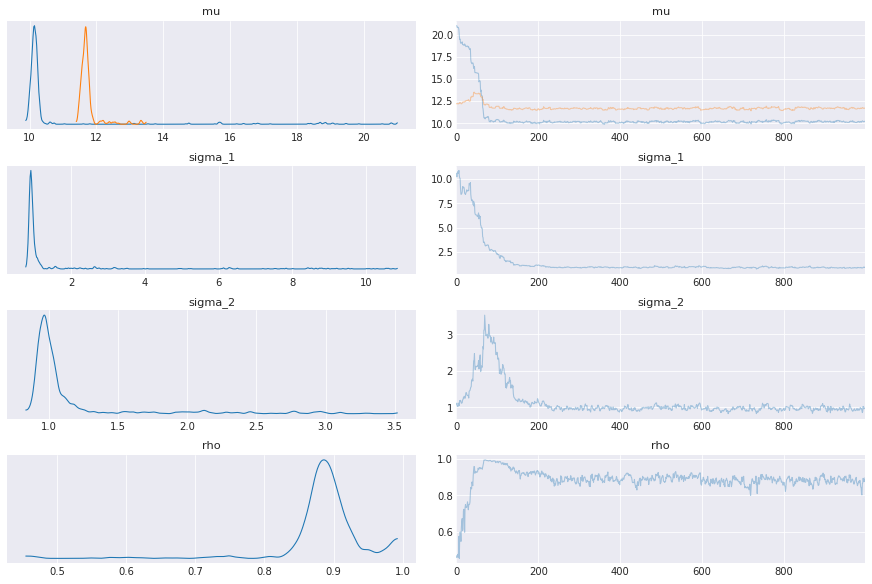

In [25]:
az.plot_trace(mcmc_run_n, compact=True)
plt.savefig('B04958_04_12.png', dpi=300)

## Robust linear regression


In [28]:
ans = sns.load_dataset('anscombe')
x_3 = ans[ans.dataset == 'III']['x'].values
y_3 = ans[ans.dataset == 'III']['y'].values

/home/kajyuuen/.pyenv/versions/3.7.5/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error two minor releases later
  


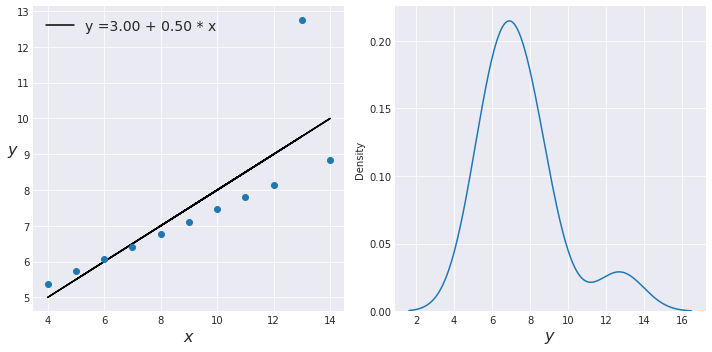

In [29]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
beta_c, alpha_c = stats.linregress(x_3, y_3)[:2]
plt.plot(x_3, (alpha_c + beta_c* x_3), 'k',
         label='y ={:.2f} + {:.2f} * x'.format(alpha_c, beta_c))
plt.plot(x_3, y_3, 'C0o')
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', rotation=0, fontsize=16)
plt.legend(loc=0, fontsize=14)
plt.subplot(1,2,2)
sns.kdeplot(y_3);
plt.xlabel('$y$', fontsize=16)
plt.tight_layout()
plt.savefig('B04958_04_13.png', dpi=300, figsize=(5.5, 5.5));

$$\alpha \sim {\rm Normal}(\mu_\alpha, \sigma_\alpha)$$
$$\beta \sim {\rm Normal}(\mu_\beta, \sigma_\beta)$$
$$\epsilon \sim {\rm HalfCauchy(\sigma_\sigma)}$$
$$\nu \sim {\rm Exponential}(1/29)+1$$
$${\boldsymbol y} \sim {\rm StudentT}(\mu=\alpha+\beta{\boldsymbol x}, \sigma =\epsilon, \nu=\nu)$$

In [68]:
def model_t(x_3, y_3=None):
    alpha = pyro.sample("alpha", pyro.distributions.Normal(0, 100))
    beta = pyro.sample("beta", pyro.distributions.Normal(0, 1))
    epsilon = pyro.sample("epsilon", pyro.distributions.HalfCauchy(5))
    nu = pyro.sample("mu", pyro.distributions.Exponential(torch.tensor([1/29])))
    with pyro.plate("data", size = len(x_3)):
        mu = alpha + beta * x_3
        y = pyro.sample("y", pyro.distributions.StudentT(nu+1, mu, epsilon), obs=y_3)

In [69]:
nuts_kernel_t = pyro.infer.mcmc.NUTS(model_t)
mcmc_run_t = pyro.infer.mcmc.MCMC(nuts_kernel_t, num_samples=2000, warmup_steps=100, num_chains=1)
mcmc_run_t.run(torch.tensor(x_3), torch.tensor(y_3))

Sample: 100%|██████████| 2100/2100 [08:49,  3.97it/s, step size=1.30e-02, acc. prob=0.622]


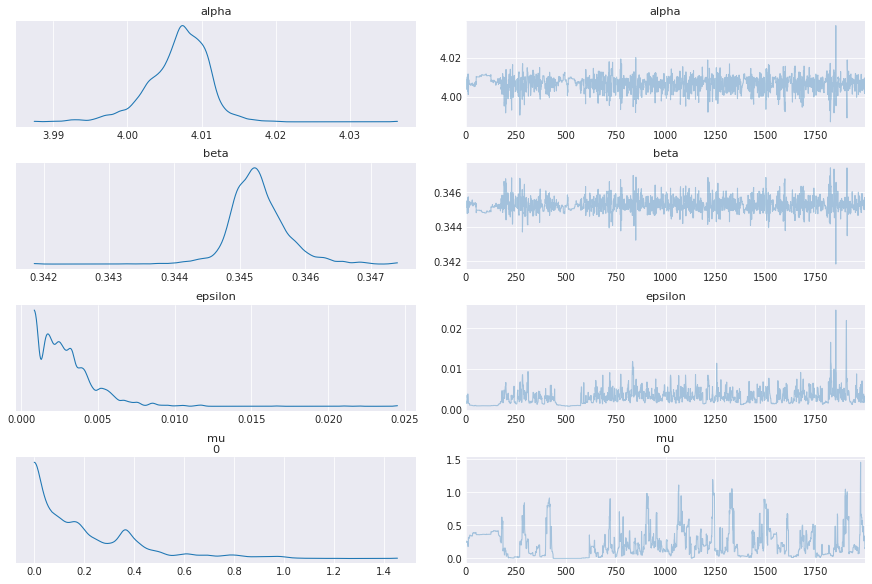

In [75]:
az.plot_trace(mcmc_run_t)
plt.savefig('B04958_04_12.png', dpi=300)

In [90]:
trace_t = mcmc_run_t.get_samples(1100)

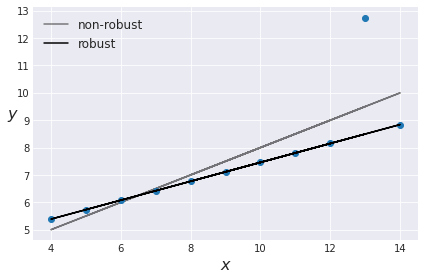

In [91]:
beta_c, alpha_c = stats.linregress(x_3, y_3)[:2]

plt.plot(x_3, (alpha_c + beta_c * x_3), 'k', label='non-robust', alpha=0.5)
plt.plot(x_3, y_3, 'C0o')
alpha_m = trace_t['alpha'].mean()
beta_m = trace_t['beta'].mean()
plt.plot(x_3, alpha_m + beta_m * x_3, c='k', label='robust')

plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', rotation=0, fontsize=16)
plt.legend(loc=2, fontsize=12)
plt.tight_layout()

plt.savefig('B04958_04_14.png', dpi=300);

In [92]:
# pm.sample_posterior_predictive
y_preds = pyro.infer.Predictive(model_t, mcmc_run_t.get_samples(200))(x_3)

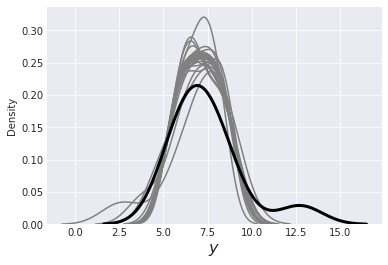

In [98]:
# predicted data
for y_tilde in y_preds['y']:
    sns.kdeplot(y_tilde, alpha=0.5, color='gray')

# actual data
sns.kdeplot(y_3, linewidth=3, color='k')
plt.xlabel('$y$', fontsize=16)
plt.savefig('B04958_04_15.png', dpi=300);

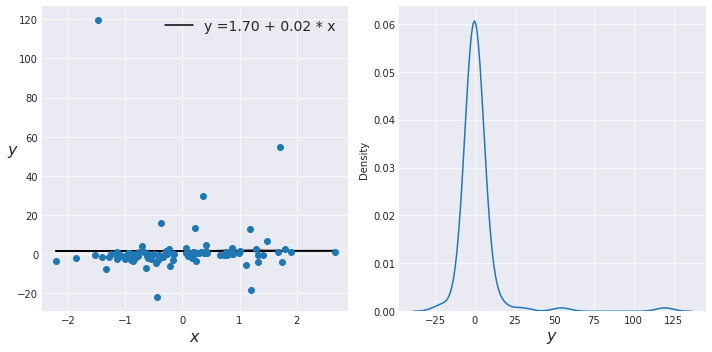

In [99]:
np.random.seed(314)
x_4 = np.random.normal(size=100)
y_4 = x_4 + np.random.standard_t(df=1, size=100) # experiments with different values of df

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
beta_c, alpha_c = stats.linregress(x_4, y_4)[:2]
plt.plot(x_4, (alpha_c + beta_c* x_4), 'k', 
         label='y ={:.2f} + {:.2f} * x'.format(alpha_c, beta_c))
plt.plot(x_4, y_4, 'C0o')
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', rotation=0, fontsize=16)
plt.legend(loc=0, fontsize=14)
plt.subplot(1,2,2)
sns.kdeplot(y_4);
plt.xlabel('$y$', fontsize=16)
plt.tight_layout()

## Hierarchical linear regression

In [4]:
# 遅すぎるのでここからはnumpyroで…
import numpyro
import numpy as np

In [168]:
N = 20
M = 8
idx = np.repeat(range(M-1), N)
idx = np.append(idx, 7)
np.random.seed(314)

alpha_real = np.random.normal(2.5, 0.5, size=M)
beta_real = np.random.beta(6, 1, size=M)
eps_real = np.random.normal(0, 0.5, size=len(idx))

y_m = np.zeros(len(idx))
x_m = np.random.normal(10, 1, len(idx))
y_m = alpha_real[idx] + beta_real[idx] * x_m  + eps_real

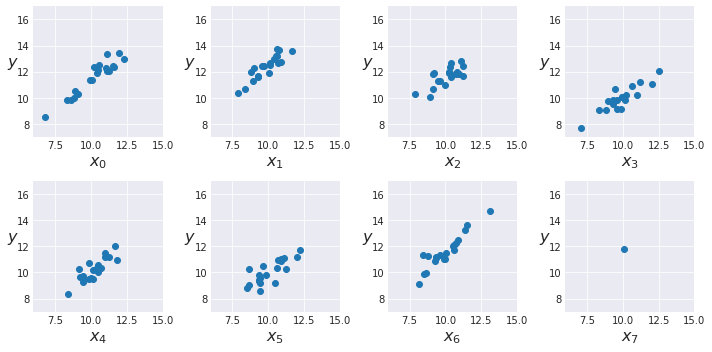

In [169]:
plt.figure(figsize=(10,5))
j, k = 0, N
for i in range(M):
    plt.subplot(2,4,i+1)
    plt.scatter(x_m[j:k], y_m[j:k])
    plt.xlabel('$x_{}$'.format(i), fontsize=16)
    plt.ylabel('$y$', fontsize=16, rotation=0)
    plt.xlim(6, 15)
    plt.ylim(7, 17)
    j += N
    k += N
plt.tight_layout()
plt.savefig('B04958_04_16.png', dpi=300)

In [170]:
x_centered = x_m - x_m.mean()

In [193]:
def unpooled_model(idx, x_m, y_m = None):
    with numpyro.plate("class", size = M):
        tmp_a = numpyro.sample("tmp_a", numpyro.distributions.Normal(0, 10))
        beta = numpyro.sample("beta", numpyro.distributions.Normal(0, 10))

    epsilon = numpyro.sample("epsilon", numpyro.distributions.HalfCauchy(5))
    nu = numpyro.sample("nu", numpyro.distributions.Exponential(1/30))

    with numpyro.plate("data", size = len(idx)):
        mu = tmp_a[idx] + beta[idx] * x_m
        y_pred = numpyro.sample("y_pred", numpyro.distributions.StudentT(nu, loc=mu, scale=epsilon), obs=y_m)    

    alpha = numpyro.deterministic("alpha", tmp_a[idx] - beta[idx] * x_m.mean())

In [197]:
from jax import random
rng_key = random.PRNGKey(1)
nuts_kernel_u = numpyro.infer.NUTS(unpooled_model)
mcmc_run_u = numpyro.infer.MCMC(nuts_kernel_u, num_samples=2000, num_warmup=3000)
mcmc_run_u.run(rng_key, np.array(idx), np.array(x_m), y_m=np.array(y_m))

sample: 100%|██████████| 5000/5000 [00:10<00:00, 480.84it/s, 255 steps of size 3.27e-02. acc. prob=0.92]


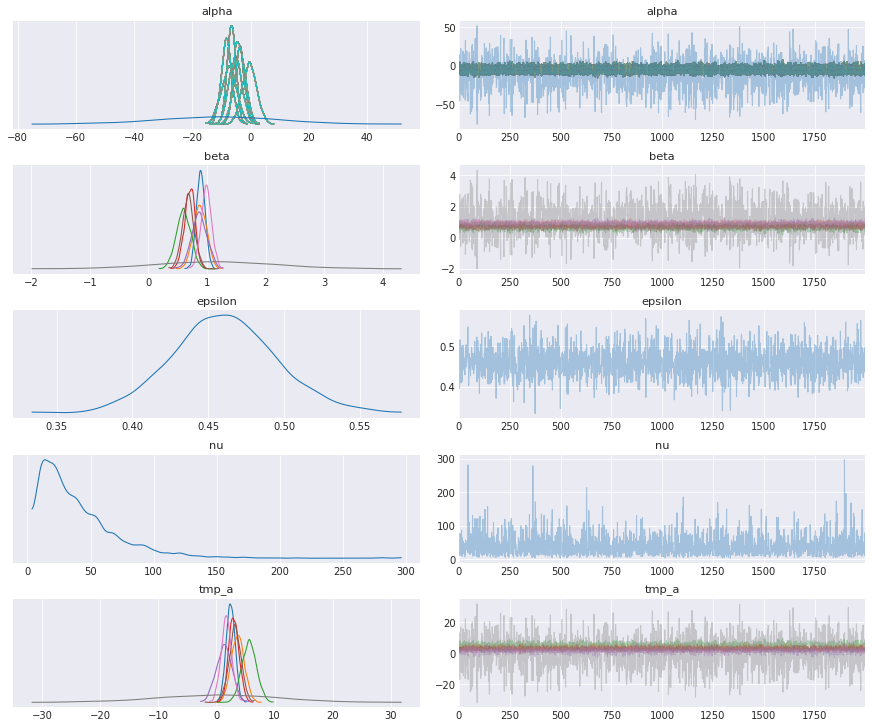

In [198]:
varnames = ["alpha", "beta", "epsilon", "nu"]
az.plot_trace(mcmc_run_u, compact=True, filter_vars=varnames)
plt.savefig('B04958_04_17.png', dpi=300)

In [201]:
mcmc_run_u.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]      0.89      0.07      0.89      0.78      1.01   1306.80      1.00
   beta[1]      0.88      0.11      0.88      0.69      1.05   1442.73      1.00
   beta[2]      0.60      0.12      0.60      0.40      0.80   1309.51      1.00
   beta[3]      0.70      0.09      0.71      0.56      0.85   1843.63      1.00
   beta[4]      0.87      0.13      0.87      0.66      1.09   1814.69      1.00
   beta[5]      0.68      0.10      0.68      0.51      0.85   1614.44      1.00
   beta[6]      0.99      0.09      0.99      0.83      1.13   1599.49      1.00
   beta[7]      1.15      1.01      1.15     -0.54      2.80   1541.98      1.00
   epsilon      0.46      0.04      0.46      0.41      0.52   2119.44      1.00
        nu     39.91     31.30     31.37      4.49     81.40   1941.68      1.00
  tmp_a[0]      2.43      0.75      2.42      1.28      3.74   1301.54      1.00
  tmp_a[1]      3.65      1

実装に間違えがある…？

$$\mu_\alpha \sim {\rm Normal}(\mu_{\mu_\alpha}, \sigma_{\mu_\alpha})$$
$$\sigma_\alpha \sim {\rm HalfCauchy(\sigma_{\sigma_\alpha})}$$
$$\mu_\beta \sim {\rm Normal}(\mu_{\mu_\beta}, \sigma_{\mu_\beta})$$
$$\sigma_\beta \sim {\rm HalfCauchy(\sigma_{\sigma_\beta})}$$
$$\alpha \sim {\rm Normal}(\mu_\alpha, \sigma_\alpha)$$
$$\beta \sim {\rm Normal}(\mu_\beta, \sigma_\beta)$$
$$\sigma \sim {\rm HalfCauchy(\sigma_\sigma)}$$
$$\nu \sim {\rm Exponential}(1/30)$$
$${\boldsymbol y} \sim {\rm StudentT}(\mu=\alpha+\beta{\boldsymbol x}, \sigma =\epsilon, \nu=\nu)$$

In [245]:
def hierarchical_model(idx, x_m, y_m = None):
    # hyper-priors
    alpha_tmp_mu = numpyro.sample("alpha_tmp_mu", numpyro.distributions.Normal(0, 10))
    alpha_tmp_std = numpyro.sample("alpha_tmp_std", numpyro.distributions.HalfNormal(10))
    beta_mu = numpyro.sample("beta_mu", numpyro.distributions.Normal(0, 10))
    beta_std = numpyro.sample("beta_std", numpyro.distributions.HalfNormal(10))

    # a prioris    
    with numpyro.plate("class", size=M):
        alpha_tmp = numpyro.sample("alpha_tmp", numpyro.distributions.Normal(loc=alpha_tmp_mu, scale=alpha_tmp_std))
        beta = numpyro.sample("beta", numpyro.distributions.Normal(loc=beta_mu, scale=beta_std))

    epsilon = numpyro.sample("epsilon", numpyro.distributions.HalfCauchy(5))
    nu = numpyro.sample("nu", numpyro.distributions.Exponential(1/30))

    with numpyro.plate("data", size = len(idx)):
        mu = alpha_tmp[idx] + beta[idx] * x_m
        y = pyro.sample("y", numpyro.distributions.StudentT(nu, loc=mu, scale=epsilon), obs=y_m)    

    alpha = numpyro.deterministic("alpha", alpha_tmp - beta * x_m.mean())
    alpha_mu = numpyro.deterministic("alpha_mu", alpha_tmp_mu - beta_mu * x_m.mean())
    alpha_std = numpyro.deterministic("alpha_std", alpha_tmp_std - beta_std * x_m.mean())    

In [246]:
from jax import random
rng_key = random.PRNGKey(1)
nuts_kernel_hierarchical = numpyro.infer.NUTS(hierarchical_model)
mcmc_run_hierarchical = numpyro.infer.MCMC(nuts_kernel_hierarchical, num_samples=2000, num_warmup=1000)
mcmc_run_hierarchical.run(rng_key, np.array(idx), np.array(x_centered), y_m=np.array(y_m))

/home/kajyuuen/.pyenv/versions/3.7.5/lib/python3.7/site-packages/pyro/primitives.py:86: RuntimeWarning: trying to observe a value outside of inference at y
  RuntimeWarning)
sample: 100%|██████████| 3000/3000 [00:08<00:00, 363.32it/s, 63 steps of size 1.34e-01. acc. prob=0.73]


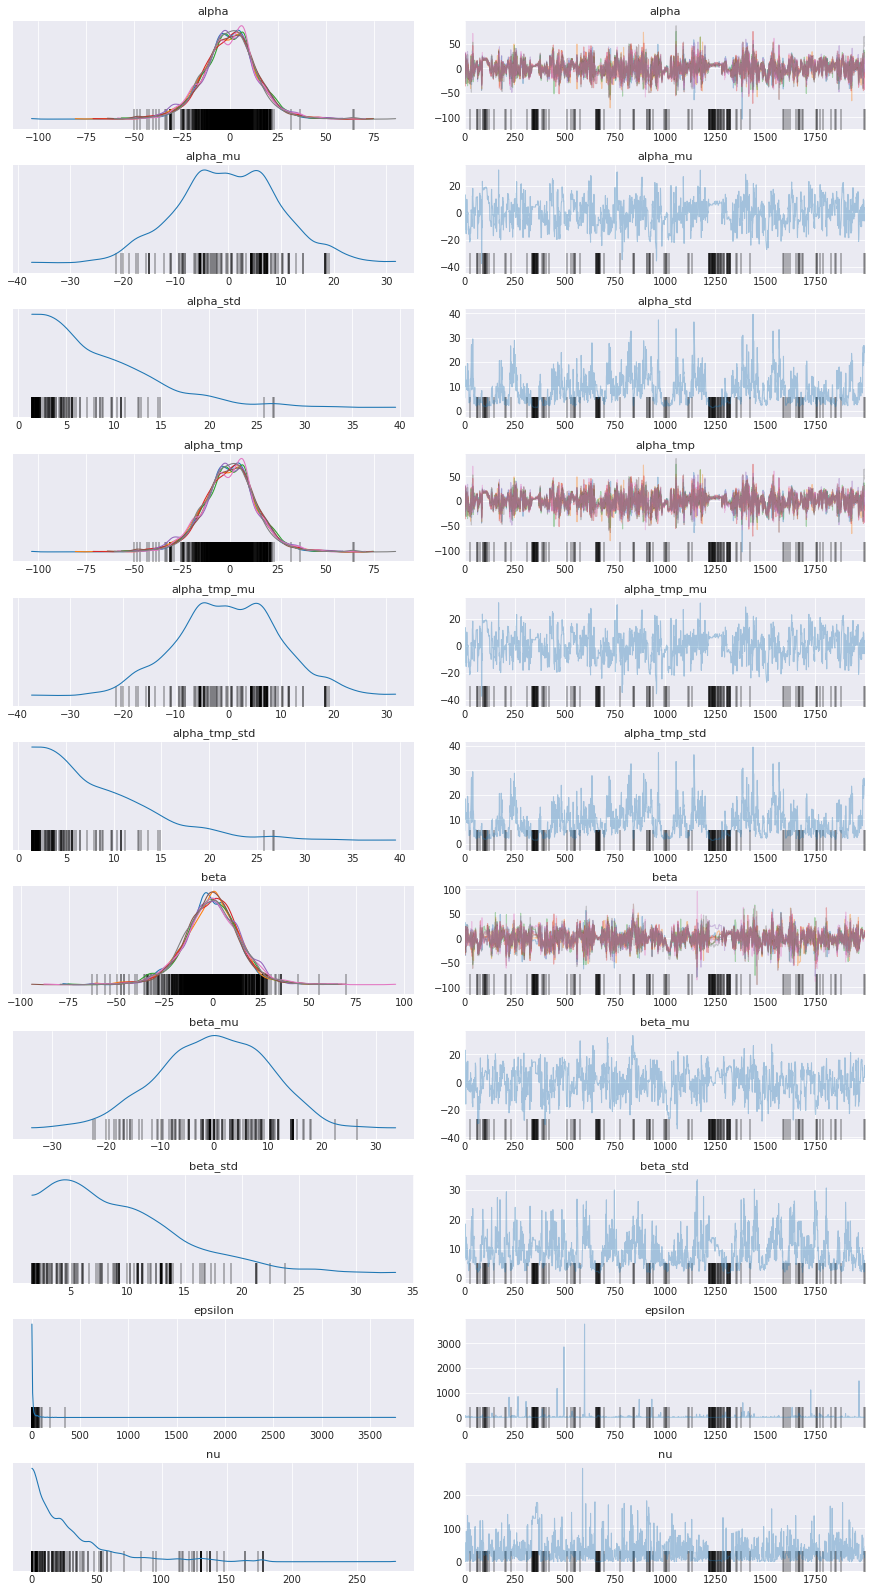

In [247]:
varnames=['alpha', 'alpha_mu', 'alpha_sd', 'beta',
          'beta_mu', 'beta_sd', 'epsilon', 'nu']
az.plot_trace(mcmc_run_hierarchical, compact=True, filter_vars=varnames)
plt.savefig('B04958_04_19_with_numpyro.png', dpi=300)

In [248]:
mcmc_run_hierarchical.print_summary()


                     mean       std    median      5.0%     95.0%     n_eff     r_hat
   alpha_tmp[0]     -0.02     14.07      0.29    -21.74     22.15    514.11      1.00
   alpha_tmp[1]     -0.39     14.81      0.00    -22.26     24.11    497.20      1.00
   alpha_tmp[2]      0.21     14.59      0.25    -22.51     24.19    469.42      1.00
   alpha_tmp[3]      0.06     14.71      0.56    -22.54     23.41    472.32      1.00
   alpha_tmp[4]     -0.02     14.86     -0.20    -23.76     26.18    455.85      1.00
   alpha_tmp[5]      0.03     14.45      0.67    -22.42     23.08    431.97      1.00
   alpha_tmp[6]      0.18     14.37      0.59    -24.83     21.20    436.11      1.00
   alpha_tmp[7]      0.09     14.39      0.21    -21.35     22.89    467.11      1.00
   alpha_tmp_mu     -0.03      9.98     -0.10    -18.43     14.34    306.67      1.00
  alpha_tmp_std      8.59      6.07      7.05      1.38     16.85     88.30      1.00
        beta[0]     -0.90     14.62     -0.92    -23.

/home/kajyuuen/.pyenv/versions/3.7.5/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error two minor releases later


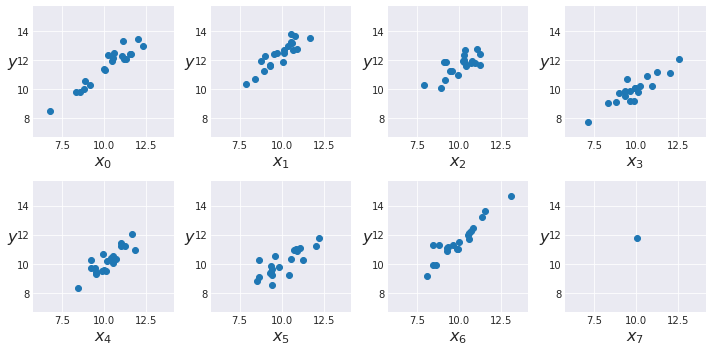

In [249]:
trace_hm = mcmc_run_hierarchical.get_samples(1000)
plt.figure(figsize=(10,5))
j, k = 0, N
x_range = np.linspace(x_m.min(), x_m.max(), 10)
for i in range(M):
    plt.subplot(2, 4, i+1)
    plt.scatter(x_m[j:k], y_m[j:k])
    plt.xlabel('$x_{}$'.format(i), fontsize=16)
    plt.ylabel('$y$', fontsize=16, rotation=0)
    alfa_m = trace_hm['alpha'][:,i].mean()
    beta_m = trace_hm['beta'][:,i].mean()
    plt.plot(x_range, alfa_m + beta_m * x_range, c='k',
             label='y = {:.2f} + {:.2f} * x'.format(alfa_m, beta_m))
    plt.xlim(x_m.min()-1, x_m.max()+1)
    plt.ylim(y_m.min()-1, y_m.max()+1)
    j += N
    k += N
plt.tight_layout()
plt.savefig('B04958_04_20.png', dpi=300, figsize=(5.5, 5.5));

## Polynomial regression

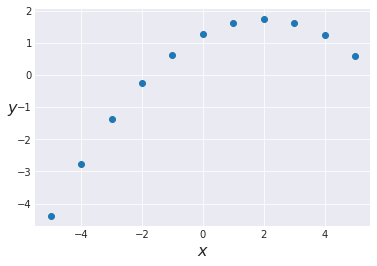

In [3]:
ans = sns.load_dataset('anscombe')
x_2 = ans[ans.dataset == 'II']['x'].values
y_2 = ans[ans.dataset == 'II']['y'].values
x_2 = x_2 - x_2.mean()
y_2 = y_2 - y_2.mean()

plt.scatter(x_2, y_2)
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0)
plt.savefig('B04958_04_21.png', dpi=300)

In [5]:
def model_poly(x_2, y_2=None):
    alpha = numpyro.sample("alpha", numpyro.distributions.Normal(loc=0, scale=10))
    beta1 = numpyro.sample("beta1", numpyro.distributions.Normal(loc=0, scale=1))
    beta2 = numpyro.sample("beta2", numpyro.distributions.Normal(loc=0, scale=1))
    
    epsilon = numpyro.sample("epsilon", numpyro.distributions.HalfCauchy(5))

    mu = alpha + beta1 * x_2 + beta2 * x_2**2
    
    with numpyro.plate("data", len(x_2)):
        y_pred = numpyro.sample("y_pred", numpyro.distributions.Normal(loc=mu, scale=epsilon), obs=y_2)

In [7]:
import jax

rng_key = jax.random.PRNGKey(1)

poly_kernel = numpyro.infer.NUTS(model_poly)
poly_mcmc = numpyro.infer.MCMC(poly_kernel, num_warmup=300, num_samples=2000)
poly_mcmc.run(rng_key, x_2, y_2)

sample: 100%|██████████| 2300/2300 [00:05<00:00, 436.20it/s, 31 steps of size 5.72e-03. acc. prob=0.94] 


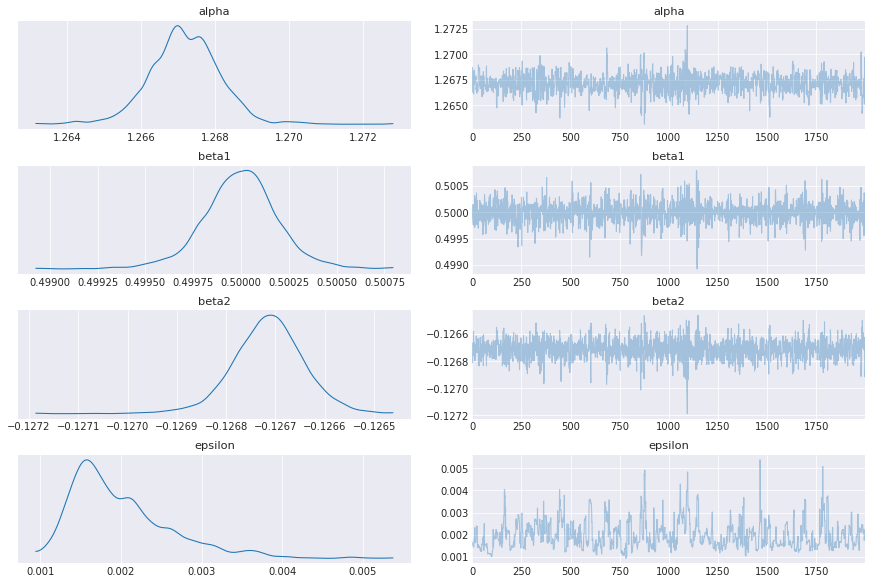

In [8]:
az.plot_trace(poly_mcmc)
plt.savefig('B04958_04_22_with_numpyro.png', dpi=300)

In [9]:
poly_mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      1.27      0.00      1.27      1.27      1.27    965.84      1.00
     beta1      0.50      0.00      0.50      0.50      0.50   1787.98      1.00
     beta2     -0.13      0.00     -0.13     -0.13     -0.13   1263.65      1.00
   epsilon      0.00      0.00      0.00      0.00      0.00    153.60      1.00

Number of divergences: 0


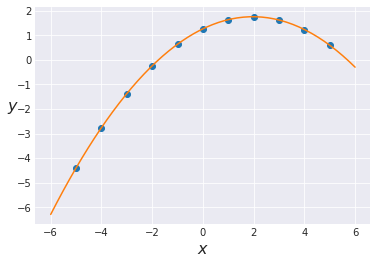

In [12]:
posterior_samples = poly_mcmc.get_samples()
x_p = np.linspace(-6, 6)
y_p = posterior_samples['alpha'].mean() + posterior_samples['beta1'].mean() * x_p + posterior_samples['beta2'].mean() * x_p**2
plt.scatter(x_2, y_2)
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0)
plt.plot(x_p, y_p, c='C1')
plt.savefig('B04958_04_23.png', dpi=300);

## Multiple Linear regression

In [2]:
np.random.seed(314)
N = 100
alpha_real = 2.5
beta_real = [0.9, 1.5]
eps_real = np.random.normal(0, 0.5, size=N)

X = np.array([np.random.normal(i, j, N) for i,j in zip([10, 2], [1, 1.5])])
X_mean = X.mean(axis=1, keepdims=True)
X_centered = X - X_mean
y = alpha_real + np.dot(beta_real, X) + eps_real

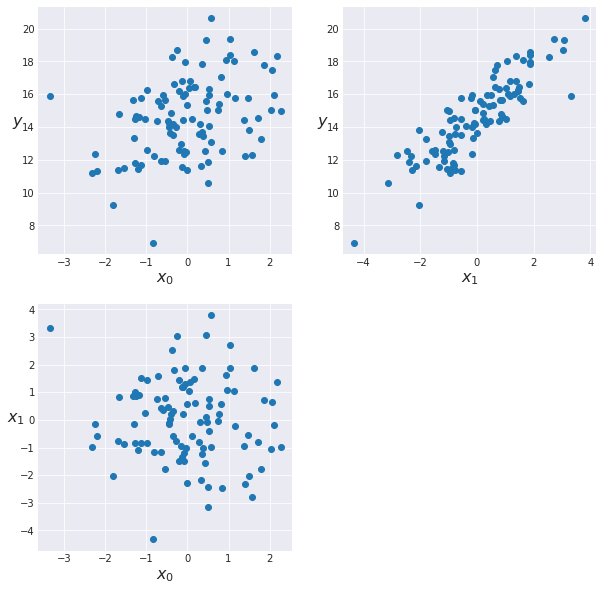

In [3]:
def scatter_plot(x, y):
    plt.figure(figsize=(10, 10))
    for idx, x_i in enumerate(x):
        plt.subplot(2, 2, idx+1)
        plt.scatter(x_i, y)
        plt.xlabel('$x_{}$'.format(idx), fontsize=16)
        plt.ylabel('$y$', rotation=0, fontsize=16)

    plt.subplot(2, 2, idx+2)
    plt.scatter(x[0], x[1])
    plt.xlabel('$x_{}$'.format(idx-1), fontsize=16)
    plt.ylabel('$x_{}$'.format(idx), rotation=0, fontsize=16)

scatter_plot(X_centered, y)
plt.savefig('B04958_04_25.png', dpi=300);

In [10]:
def model_mlr(x_mean, x_centered, y=None):
    alpha_tmp = numpyro.sample("alpha_tmp", numpyro.distributions.Normal(loc=0, scale=10))
    with numpyro.plate("coefficients", size=2):
        beta = numpyro.sample("beta", numpyro.distributions.Normal(loc=0, scale=1))
    epsilon = numpyro.sample("epsilon", numpyro.distributions.HalfCauchy(5))

    alpha = numpyro.deterministic("alpha", alpha_tmp - jnp.dot(beta, x_mean))
    mu = alpha_tmp + jnp.dot(beta, x_centered)

    with numpyro.plate("data", size = N):
        y_pred = numpyro.sample("y_pred", numpyro.distributions.Normal(loc=mu, scale=epsilon), obs=y)

In [11]:
rng_key = jax.random.PRNGKey(1)

poly_mlr = numpyro.infer.NUTS(model_mlr)
poly_mlr = numpyro.infer.MCMC(poly_mlr, num_warmup=300, num_samples=2000)
poly_mlr.run(rng_key, X_mean, X_centered, np.array(y))

sample: 100%|██████████| 2300/2300 [00:05<00:00, 449.28it/s, 7 steps of size 7.44e-01. acc. prob=0.91]


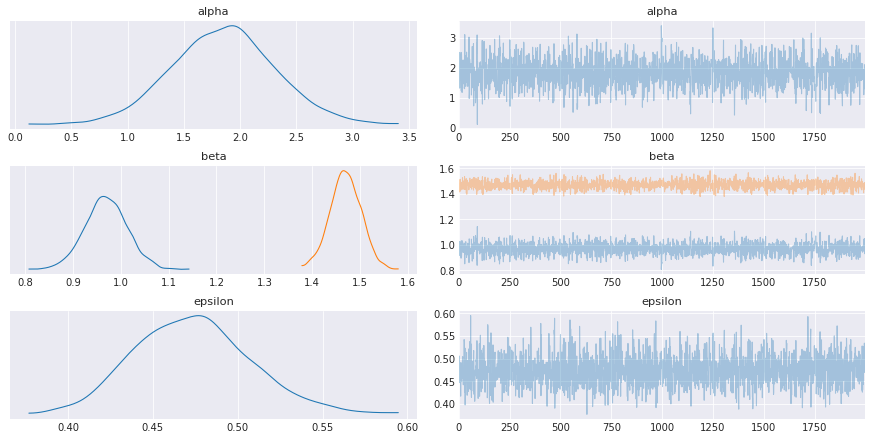

In [15]:
az.plot_trace(poly_mlr, var_names=["alpha", "beta", "epsilon"], compact=True)
plt.savefig('B04958_04_26_with_numpyro.png', dpi=300);

In [17]:
poly_mlr.print_summary(exclude_deterministic=False)


                 mean       std    median      5.0%     95.0%     n_eff     r_hat
   alpha[0]      1.85      0.46      1.86      1.10      2.59   1963.97      1.00
  alpha_tmp     14.60      0.05     14.60     14.52     14.68   2268.57      1.00
    beta[0]      0.97      0.04      0.97      0.89      1.04   2039.32      1.00
    beta[1]      1.47      0.03      1.47      1.42      1.52   2088.41      1.00
    epsilon      0.47      0.03      0.47      0.42      0.53   1990.00      1.00

Number of divergences: 0


## Confounding variables and redundant variables

In [27]:
np.random.seed(314)
N = 100
x_1 = np.random.normal(size=N)
x_2 = x_1 + np.random.normal(size=N, scale=1)
#x_2 = x_1 + np.random.normal(size=N, scale=0.01)  
y = x_1 + np.random.normal(size=N)
X = np.vstack((x_1, x_2))

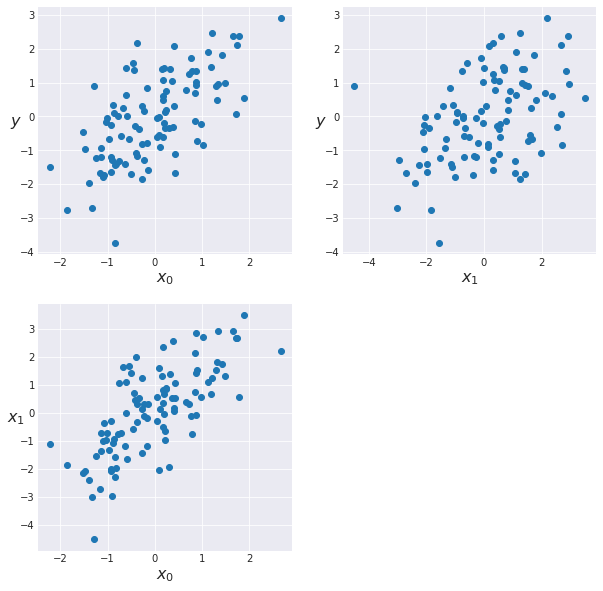

In [28]:
scatter_plot(X, y)
plt.savefig('B04958_04_27.png', dpi=300);

In [47]:
def model_red(X, y=None):
    alpha = numpyro.sample("alpha", numpyro.distributions.Normal(0, 1))

    with numpyro.plate("coefficients", size=2):
        beta = numpyro.sample("beta", numpyro.distributions.Normal(0, 10))
    epsilon = numpyro.sample("epsilon", numpyro.distributions.HalfCauchy(5))
    
    mu = alpha + jnp.dot(beta, X)
    
    with numpyro.plate("data", size=len(X[0])):
        y_pred = numpyro.sample("y_pred", numpyro.distributions.Normal(mu, epsilon), obs=y)

In [48]:
rng_key = jax.random.PRNGKey(1)

mcmc_red = numpyro.infer.NUTS(model_red)
mcmc_red_mcmc = numpyro.infer.MCMC(mcmc_red, num_warmup=300, num_samples=5000)
mcmc_red_mcmc.run(rng_key, X, y)

sample: 100%|██████████| 5300/5300 [00:07<00:00, 694.96it/s, 3 steps of size 4.81e-01. acc. prob=0.94]  


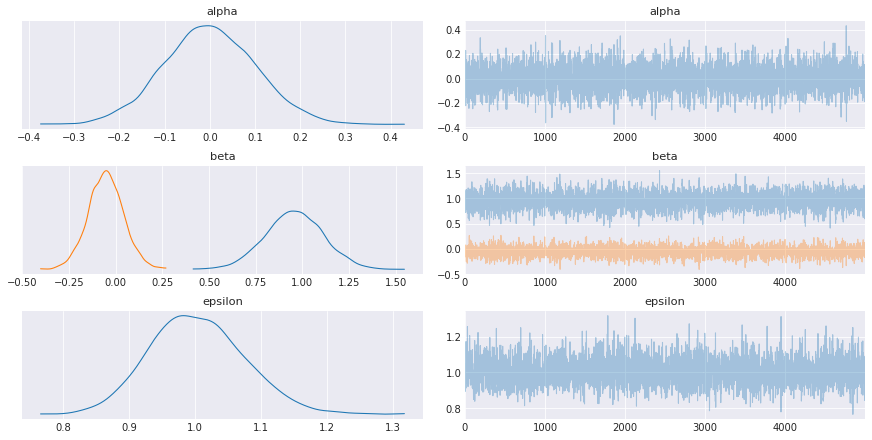

In [49]:
az.plot_trace(mcmc_red_mcmc, compact=True)
plt.savefig('B04958_04_28_with_numpyro.png', dpi=300);

In [50]:
mcmc_red_mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      0.00      0.10     -0.00     -0.16      0.18   5101.34      1.00
   beta[0]      0.96      0.16      0.96      0.70      1.21   2789.12      1.00
   beta[1]     -0.05      0.10     -0.05     -0.22      0.10   2945.56      1.00
   epsilon      1.00      0.07      1.00      0.89      1.12   3531.10      1.00

Number of divergences: 0


/home/kajyuuen/.pyenv/versions/3.7.5/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error two minor releases later
  """


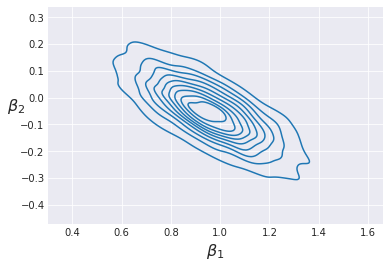

In [55]:
posterior_samples = mcmc_red_mcmc.get_samples()
sns.kdeplot(posterior_samples['beta'][:,0], posterior_samples['beta'][:,1])
plt.xlabel(r'$\beta_1$', fontsize=16)
plt.ylabel(r'$\beta_2$', fontsize=16, rotation=0)
plt.savefig('B04958_04_29.png', dpi=300, figsize=(5.5, 5.5));

## Masking effect variables

In [60]:
np.random.seed(314)
N = 100
r = 0.8
x_0 = np.random.normal(size=N)
x_1 = np.random.normal(loc=x_0 * r, scale=(1 - r ** 2) ** 0.5)
y = np.random.normal(loc=x_0 - x_1)
X = np.vstack((x_0, x_1))

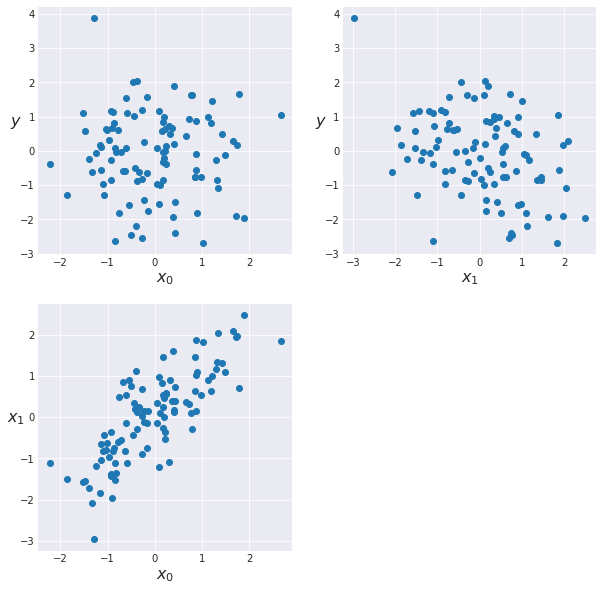

In [62]:
scatter_plot(X, y)
plt.savefig('B04958_04_31.png', dpi=300)

In [63]:
def model_ma(X, y=None):
    alpha = numpyro.sample("alpha", numpyro.distributions.Normal(0, 10))

    with numpyro.plate("coefficients", size=2):
        beta = numpyro.sample("beta", numpyro.distributions.Normal(0, 10))
    epsilon = numpyro.sample("epsilon", numpyro.distributions.HalfCauchy(5))
    
    mu = alpha + jnp.dot(beta, X)
    
    with numpyro.plate("data", size=len(X[0])):
        y_pred = numpyro.sample("y_pred", numpyro.distributions.Normal(mu, epsilon), obs=y)

In [64]:
rng_key = jax.random.PRNGKey(1)

mcmc_ma = numpyro.infer.NUTS(model_ma)
mcmc_ma_mcmc = numpyro.infer.MCMC(mcmc_red, num_warmup=300, num_samples=5000)
mcmc_ma_mcmc.run(rng_key, X, y)

sample: 100%|██████████| 5300/5300 [00:08<00:00, 606.29it/s, 7 steps of size 4.29e-01. acc. prob=0.94]  


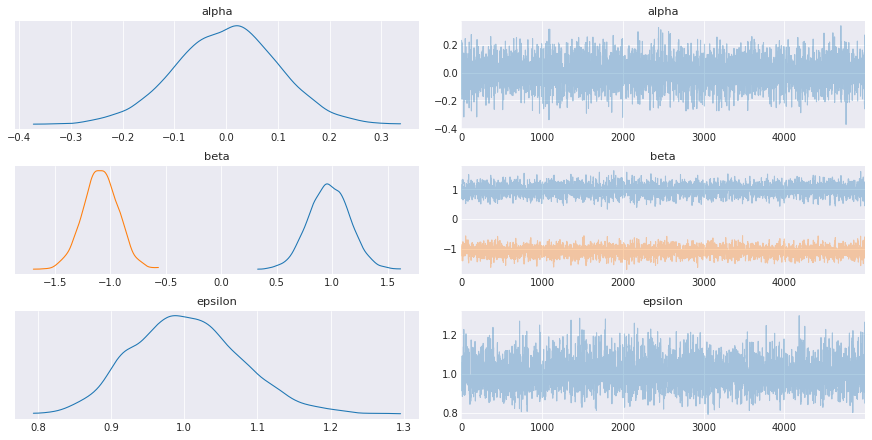

In [65]:
az.plot_trace(mcmc_ma_mcmc, compact=True)
plt.savefig('B04958_04_32_with_numpyro.png', dpi=300);

In [66]:
mcmc_ma_mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      0.00      0.10      0.00     -0.16      0.16   4553.97      1.00
   beta[0]      0.97      0.18      0.97      0.67      1.26   2279.36      1.00
   beta[1]     -1.09      0.16     -1.09     -1.34     -0.83   2419.91      1.00
   epsilon      1.00      0.07      1.00      0.89      1.13   2650.67      1.00

Number of divergences: 0
